## Motivation {.unnumbered}

Before futher analysis, identifying and removing poor quality cells is a critical step to ensure quality of the data and prevent misinformative results. nFeature/nCount and the fraction of mitochondrial, ribosomal, haemoglobin, T/B-cell recepter (TCR/BCR) reads are crucial parameters to indicate poor quality cells.
  
* High nFeature/nCount usually indicates <b>doublets</b>, whilst the opposite usually indicates <b>negative cells (empty droplets)</b>. 
* High mitochondrial fractions is a typical characteristic of <b>apoptotic</b> cells in scRNAseq data. 
* High ribosomal indicates <b>poor sample quality</b>.
* High haemoglobin fractions suggests <b>RBC contamination</b>.
  
:::{.callout-note}
## Aim
* Run wrapper functions to calculate the fraction of mitochondrial, ribosomal, haemoglobin, T/B-cell recepter (TCR/BCR) reads.
* Remove VDJ genes if your interests are T-cells and B-cells.
* Set hard and soft filter thresholds to remove negative cells and doublets
:::

## Setup

In [1]:
# set up environment
suppressMessages({
library(scUnify)
library(clustree)
setwd("/nemo/lab/caladod/working/Matthew/project/matthew/MH_GSE247917")})

# import seurat object
obj <- qread("seurat/1_processing/1.3_GSE247917_demux.qs")

Warning message:
“replacing previous import ‘cowplot::get_legend’ by ‘ggpubr::get_legend’ when loading ‘scUnify’”
Warning message:
“replacing previous import ‘cowplot::align_plots’ by ‘patchwork::align_plots’ when loading ‘scUnify’”
Warning message:
“replacing previous import ‘biomaRt::select’ by ‘rstatix::select’ when loading ‘scUnify’”
Warning message:
“replacing previous import ‘scales::viridis_pal’ by ‘viridis::viridis_pal’ when loading ‘scUnify’”


## Calculate Gene Fractions {#sec-calculate_gene_fractions}
  
The function below will perform the calculations of key quality control parameters for every cell but will not filter any cells yet. This is done by calculating the no. of selected reads over the no. of total reads for every cell.

In [2]:
calculate_fractions <- function(x){
    x <- PercentageFeatureSet(x, pattern = "^[Mm][Tt]-", col.name = "pct.mt")
    x <- PercentageFeatureSet(x, pattern = "^R[Pp][SsLl]", col.name = "pct.rb")
    x <- PercentageFeatureSet(x, pattern = "^H[ABGH][A-Z]?\\d*$|^H[abgh][a-z]?\\d*", col.name = "pct.hb")
    x <- PercentageFeatureSet(x, pattern = "^T[Rr][ABCDGabcdg][VDJCvdjc]", col.name = "pct.tcr")
    x <- PercentageFeatureSet(x, pattern = "^I[Gg][HKLhkl][VDJCAEMGvdjcaemg]", col.name = "pct.bcr")
    x <- PercentageFeatureSet(x, pattern =  "^HLA-|^H2-", col.name = "pct.mhc")
    return(x)}

In [3]:
# run calculate gene fractions if haven't done so already
obj <- calculate_fractions(obj)

## Remove VDJ Genes {#sec-remove_vdj_genes}
In the case of T/B-cells, removing VDJ genes could be critical prior to subsequence steps to avoid cell clustering by VDJ genes, especially by isotype such as IgG and IgM for B-cells. Below is a wrapper function to remove VDJ genes from the Seurat object.

:::{.callout-warning}
Before removing VDJ genes, please run Seurat::NormalizeData() to ensure library size is normalized with VDJ genes included.
:::

In [4]:
# normalize counts and remove both TCR and BCR vdj genes 
obj <- NormalizeData(obj)
obj <- remove_vdj_genes(obj, bcr = T, tcr = T)

Normalizing layer: counts

Warning message:
“Different cells and/or features from existing assay RNA”
Warning message:
“Different cells and/or features from existing assay RNA”


## Setting QC Filters {#sec-set_qc_filters}

Following @sec-calculate_gene_fractions, we will now set thresholds to remove poor quality cells mentioned above. There are generally 2 approaches - either hard and soft threshold could be set to remove cells. The difference between the methods is that using a soft threshold means that you are defining poor quality cells based on the distribution of the population, which ensures a good proportion of cells will remain and hopefully are the cells of interest. Generally we recommend using a <u>soft</u> threshold for quality control, especially in the case where users have multiple sequencing runs, as these threshold may subject to change depending on cell populations, batch effects etc.

For both approaches, a threshold is set for the following essential quality control parameters, including nFeatures_RNA, nCount_RNA, mitochondrial, haemoglobin fraction. Typically mitochondrial fraction threshold is set at 10% for human and 5% for mouse.

:::{.callout-warning}
If VDJ genes were removed earlier, recalculating nFeature and nCount is critical to remove cells that only contain VDJ genes which are likely empty droplets contaminated with RNA. This was done automatically in the Seurat object when VDJ were first removed.
:::

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


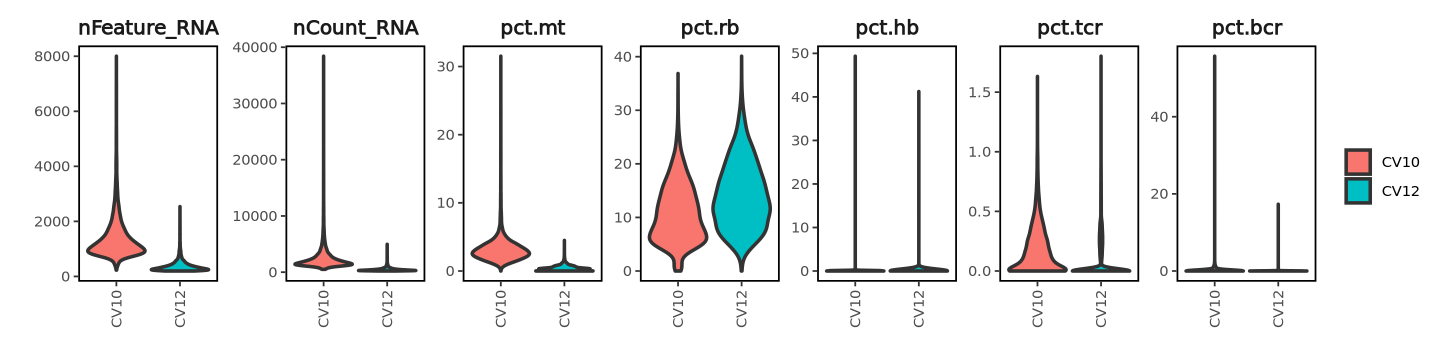

In [5]:
# visualize each quality control parameter for each sequencing run
options(repr.plot.width=12, repr.plot.height= 3)
cols <- c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.rb", "pct.hb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    ggplot(aes(x = samples, y = values, fill = samples)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~ measures, scales = "free", ncol = 7) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = "")) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()
    

### Set Hard Threshold
Given both our sequencing runs contain the similar composition of cells and distributions of the quality control parameters, we can apply the same hard thresholds to both runs. 

Warning message:
“Removed 147400 rows containing missing values or values outside the scale range
(`geom_hline()`).”


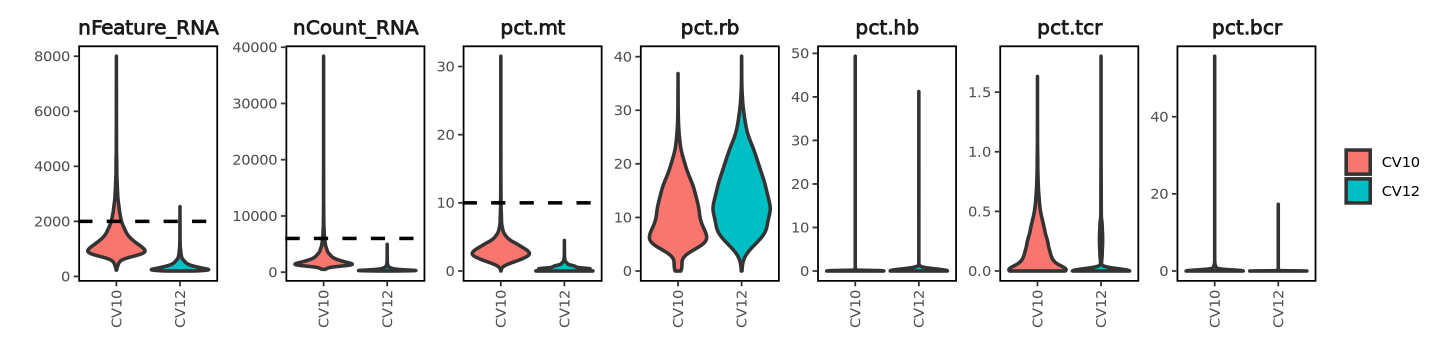

In [6]:
# visualize each quality control parameter for each sequencing run
options(repr.plot.width=12, repr.plot.height= 3)
cols <- c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.rb", "pct.hb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    ## define hard threshold
    mutate(
        yintercept = case_when(
            measures == "nCount_RNA" ~ 6000,
            measures == "nFeature_RNA" ~ 2000,
            measures == "pct.mt" ~ 10,
            .default = NULL)) %>%
            
    ggplot(aes(x = samples, y = values, fill = samples)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~ measures, scales = "free", ncol = 7) +
    geom_hline(aes(yintercept = yintercept), color = "black", linetype = "dashed", size = 1) + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = ""), color = guide_none()) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()

After visualization we removed cells based on the following criteria : 
 
* nCount_RNA > 6000
* nFeature_RNA < 200 or > 2000
* pct.mt > 10%
* pct.hb > 0%

> \> 45% cells remains from each sequencing run after quality control filter by hard threshold.

In [ ]:
# set hard threshold
obj@meta.data <- obj@meta.data %>%
    mutate(hardqc = case_when(
        .$nCount_RNA > 6000 ~ "Fail",
        .$nFeature_RNA > 2000 ~ "Fail",
        .$nFeature_RNA < 200 ~ "Fail",
        .$pct.mt > 10 ~ "Fail",
        .$pct.hb > 0 ~ "Fail",
        .default = "Pass"))
qc_report(obj, column = "hardqc", sample = "samples")

45.5% (8859) of cells remains - CV10

85.9% (14912) of cells remains - CV12



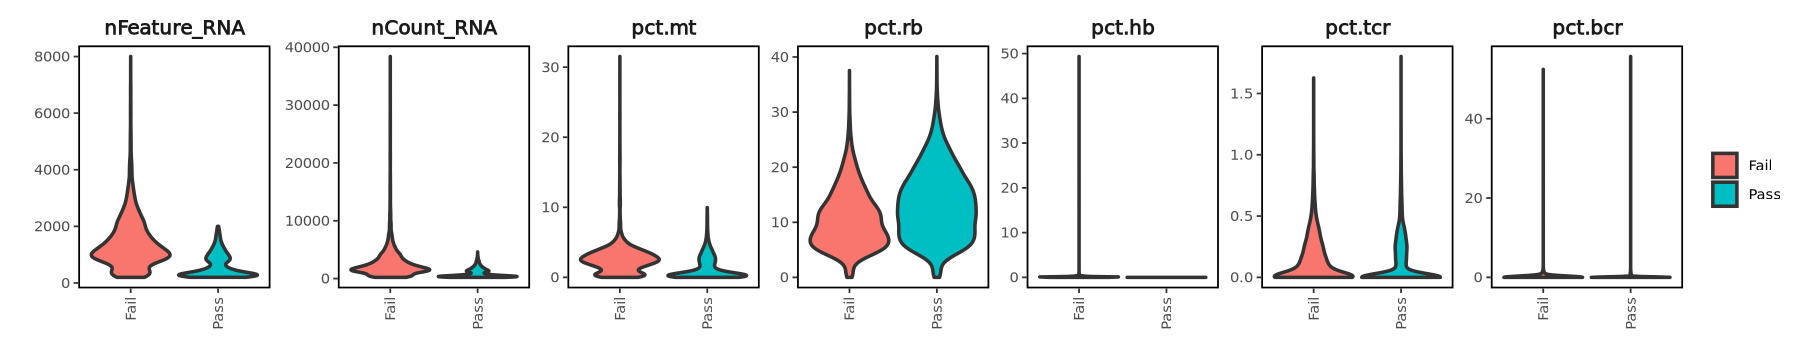

In [8]:
# visualize the quality control parameters for good/poor quality cells
options(repr.plot.width=15, repr.plot.height= 3)
cols <- c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.rb", "pct.hb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    ggplot(aes(x = hardqc, y = values, fill = hardqc)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~measures, scales = "free", ncol = 7) +
    guides(fill = guide_legend(title = "")) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    xlab("") +
    ylab("") +
    theme_border() + 
    facet_aes()
    

### Set Soft Threshold

As a comparison, we will perform soft threshold cutoff to remove outlier (poor quality) cells based on population distribution. To do so, we have adapted the median absolute deviation (MAD) method [[see details]](https://bioconductor.org/books/3.13/OSCA.basic/quality-control.html) to determine outlier cells from each sample based on the quality control filter mentioned above. Below is a wrapper function to calculate thresholds for the specified quality control parameters within 5 MAD deviations and determine outlier cells. Note the function does not perform the filtering yet.

> \> 85% cells remains from each sample after quality control filter by soft threshold.

In [9]:
# calculate mad and determine outlier cells
obj <- calculate_mad(obj, columns = c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.hb"), stdev = 5, samples = "samples")

83.4% (16246) of cells remains - CV10

81.2% (14106) of cells remains - CV12



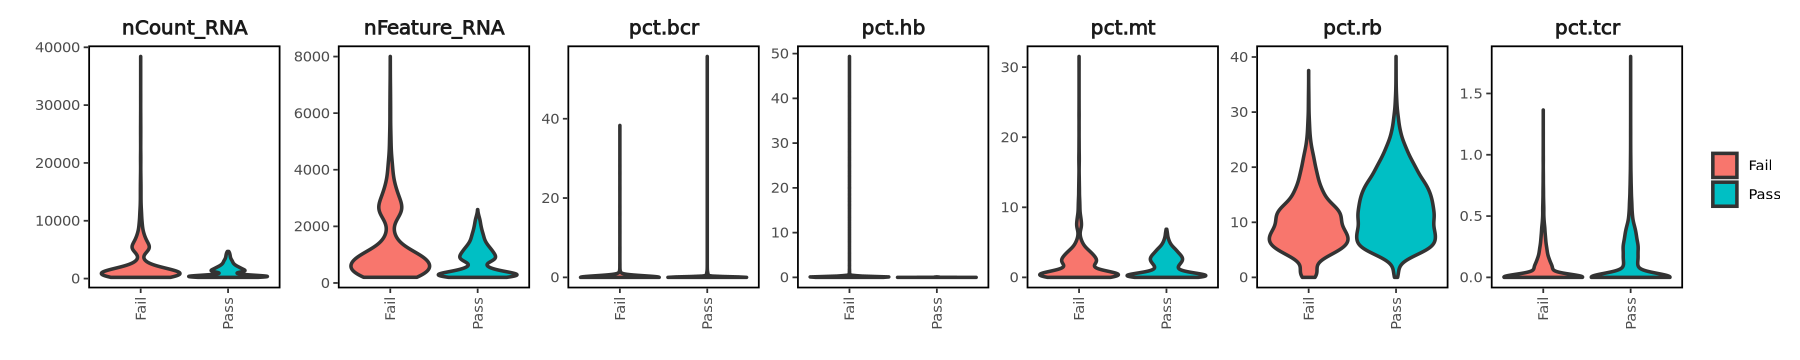

In [10]:
# visualize the quality control parameters for good/poor quality cells
options(repr.plot.width=15, repr.plot.height= 3)
cols <- c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.rb", "pct.hb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    ggplot(aes(x = softqc, y = values, fill = softqc)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~measures, scales = "free", ncol = 7) +
    guides(fill = guide_legend(title = "")) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    xlab("") +
    ylab("") +
    theme_border() + 
    facet_aes()
    

### Inspect QC Results
Given the variability of the 2 sequencing runs, we will move forward with the soft (adaptive) threshold filters to take into account. Here we will do a final inspection to ensure we are keeping the high quality cells.

In [11]:
# make scatter plots
fs1.plot <- list()
fs2.plot <- list()
fs3.plot <- list()
fs4.plot <- list()

obj_list <- SplitObject(obj, split.by = "samples")
for(x in 1:length(obj_list)){
    Idents(obj_list[[x]]) <- "samples"
    fs1.plot[[x]] <- FeatureScatter(obj_list[[x]], group.by = "softqc", "nCount_RNA", "nFeature_RNA", pt.size = 0.5, plot.cor = T) + NoLegend()
    fs2.plot[[x]] <- FeatureScatter(obj_list[[x]], group.by = "softqc", "nCount_RNA", "pct.mt", pt.size = 0.5, plot.cor = T) + NoLegend()
    fs3.plot[[x]] <- FeatureScatter(obj_list[[x]], group.by = "softqc", "pct.rb", "pct.mt", pt.size = 0.5, plot.cor = T) + NoLegend()}

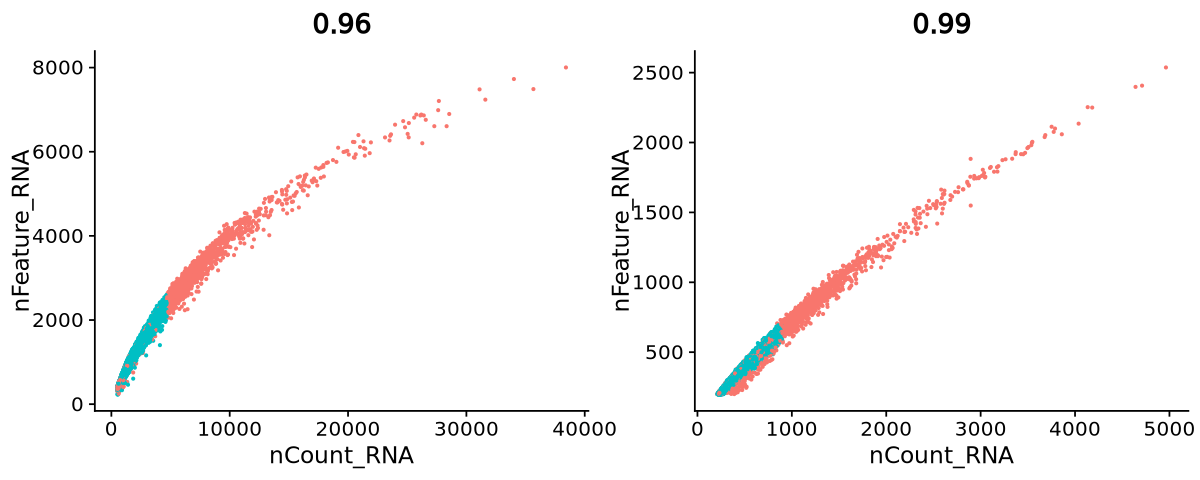

In [12]:
# nCount_RNA vs nFeature_RNA
options(repr.plot.width=10, repr.plot.height=4)
plot_grid(plotlist = fs1.plot, ncol = 2)

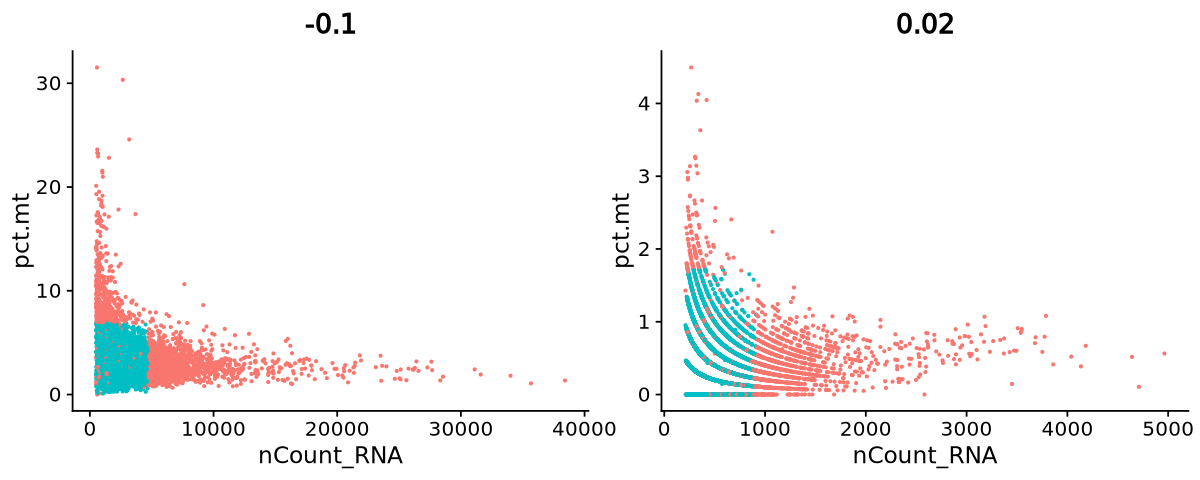

In [13]:
# nCount_RNA vs mitochondrial fraction
options(repr.plot.width=10, repr.plot.height=4)
plot_grid(plotlist = fs2.plot, ncol = 2)

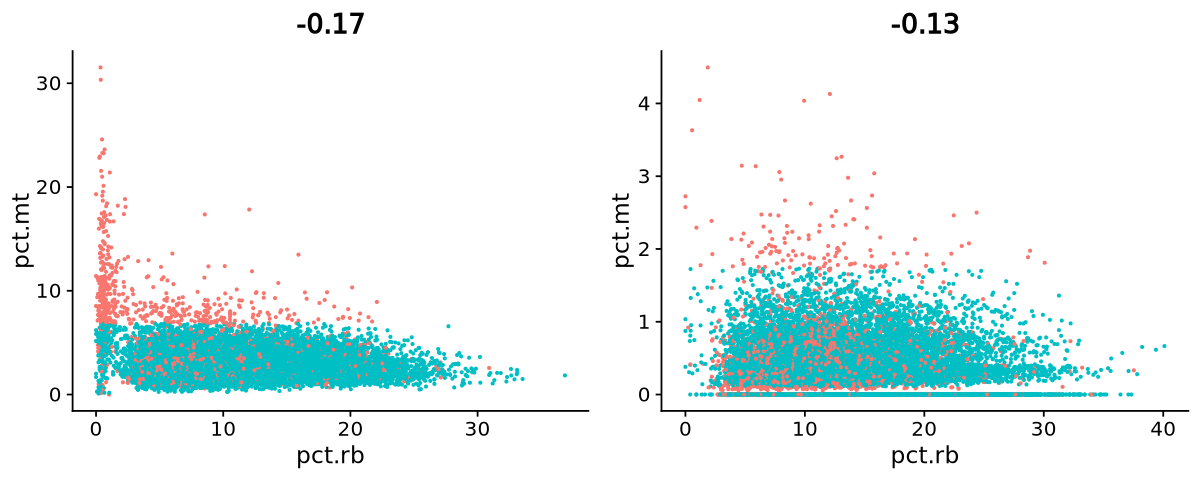

In [14]:
# ribosomal fraction vs mitochondrial fraction
options(repr.plot.width=10, repr.plot.height=4)
plot_grid(plotlist = fs3.plot, ncol = 2)

## Remove Negative Cells & Doublets {#sec-filtercells}

:::{.callout-warning}
In general, you may wish to remove the negative cells and doublets at this stage after quality control. However if you are planning to use Doublet Detection algorithms (in this case we are, see [@chapter-doublets]), please do not remove any cells at this stage as influence the proportion of doublets being called. You can remove the negative cells and doublets all together after running the doublet detection algorithms.
:::


Combining the soft threshold filters together with outputs from MULTIseqDemux in the previous chapter, we will inspect the no. of negative and doublets detected at this stage.

> \> ~35% of cells remain from each sample after all quality control filters.

In [15]:
# make a column of cells to keep, putting together outputs from multiseqdemux and quality control, but do not remove cells
obj@meta.data <- obj@meta.data %>%
    mutate(finalqc = ifelse(
        MULTI.global == "Singlet" & softqc == "Pass", "Pass", "Fail"))
qc_report(obj, column = "finalqc", sample = "samples")

70.9% (13822) of cells remains - CV10

35% (6072) of cells remains - CV12



In [16]:
## run the code below to remove cells
# obj <- subset(obj, subset = finalqc == "Pass")

## Session Info {.unnumbered}

In [17]:
qsave(obj, file = "seurat/1_processing/1.4_GSE247917_qc.qs")

In [18]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.7 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /nemo/lab/caladod/working/Matthew/.conda/envs/seurat5/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/London
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] clustree_0.5.0              ggraph_2.1.0               
 [3] scUnify_0.0.0.9000          ComplexHeatmap_2.16.0      
 [5] DoubletFinder_2.0.4         scDblFinder_1